# Variational AutoEncoder

(https://twitter.com/fchollet)<br>
Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Строим слой семплирования sampling layer


In [3]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



## Строим энкодер encoder


In [55]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 14, 14, 128)  1280        ['input_19[0][0]']               
                                                                                                  
 conv2d_22 (Conv2D)             (None, 7, 7, 256)    295168      ['conv2d_21[0][0]']              
                                                                                                  
 flatten_6 (Flatten)            (None, 12544)        0           ['conv2d_22[0][0]']              
                                                                                            

## Строим свой decoder


In [57]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_20 (Dense)            (None, 12544)             37632     
                                                                 
 reshape_13 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_51 (Conv2D  (None, 14, 14, 256)      590080    
 Transpose)                                                      
                                                                 
 conv2d_transpose_52 (Conv2D  (None, 28, 28, 64)       147520    
 Transpose)                                                      
                                                                 
 conv2d_transpose_53 (Conv2D  (None, 28, 28, 1)        577 

## Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [58]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

## Учим VAE


In [27]:
# подключение датасета
from keras.datasets import fashion_mnist

In [62]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
fashion_mnist_clothes = np.concatenate([x_train, x_test], axis=0)
fashion_mnist_clothes = np.expand_dims(fashion_mnist_clothes, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Nadam())
# vae.compile(optimizer=keras.optimizers.Adam())
vae.compile(optimizer=keras.optimizers.Adagrad())
# vae.fit(fashion_mnist_clothes, epochs=10, batch_size=128)
vae.fit(fashion_mnist_clothes, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 40s 71ms/step - loss: 327.7165 - reconstruction_loss: 322.5943 - kl_loss: 5.1222
Epoch 2/10
547/547 [==============================] - 38s 69ms/step - loss: 323.4823 - reconstruction_loss: 318.7146 - kl_loss: 4.7676
Epoch 3/10
547/547 [==============================] - 38s 70ms/step - loss: 321.1117 - reconstruction_loss: 316.4614 - kl_loss: 4.6503
Epoch 4/10
547/547 [==============================] - 38s 69ms/step - loss: 319.0969 - reconstruction_loss: 314.7292 - kl_loss: 4.3676
Epoch 5/10
547/547 [==============================] - 38s 69ms/step - loss: 317.4076 - reconstruction_loss: 313.1166 - kl_loss: 4.2910
Epoch 6/10
547/547 [==============================] - 38s 69ms/step - loss: 315.9428 - reconstruction_loss: 312.0012 - kl_loss: 3.9416
Epoch 7/10
547/547 [==============================] - 38s 69ms/step - loss: 314.5704 - reconstruction_loss: 310.8922 - kl_loss: 3.6782
Epoch 8/10
547/547 [==============================] - 3

In [63]:
vae.fit(fashion_mnist_clothes, epochs=10, batch_size=64)

Epoch 1/10
1094/1094 [==============================] - 43s 39ms/step - loss: 307.4483 - reconstruction_loss: 303.7763 - kl_loss: 3.6720
Epoch 2/10
1094/1094 [==============================] - 44s 40ms/step - loss: 306.4131 - reconstruction_loss: 302.7550 - kl_loss: 3.6581
Epoch 3/10
1094/1094 [==============================] - 42s 39ms/step - loss: 305.5794 - reconstruction_loss: 301.9515 - kl_loss: 3.6279
Epoch 4/10
1094/1094 [==============================] - 43s 39ms/step - loss: 304.8948 - reconstruction_loss: 301.3017 - kl_loss: 3.5932
Epoch 5/10
1094/1094 [==============================] - 42s 39ms/step - loss: 304.5065 - reconstruction_loss: 300.9316 - kl_loss: 3.5749
Epoch 6/10
1094/1094 [==============================] - 42s 39ms/step - loss: 304.1068 - reconstruction_loss: 300.5493 - kl_loss: 3.5575
Epoch 7/10
1094/1094 [==============================] - 42s 39ms/step - loss: 303.6946 - reconstruction_loss: 300.1559 - kl_loss: 3.5386
Epoch 8/10
1094/1094 [===================

In [64]:
vae.fit(fashion_mnist_clothes, epochs=10, batch_size=32)

Epoch 1/10
2188/2188 [==============================] - 49s 22ms/step - loss: 302.6288 - reconstruction_loss: 299.1566 - kl_loss: 3.4722
Epoch 2/10
2188/2188 [==============================] - 48s 22ms/step - loss: 302.2618 - reconstruction_loss: 298.8181 - kl_loss: 3.4438
Epoch 3/10
2188/2188 [==============================] - 54s 25ms/step - loss: 301.9457 - reconstruction_loss: 298.5198 - kl_loss: 3.4259
Epoch 4/10
2188/2188 [==============================] - 51s 23ms/step - loss: 301.6881 - reconstruction_loss: 298.2763 - kl_loss: 3.4118
Epoch 5/10
2188/2188 [==============================] - 49s 22ms/step - loss: 301.3828 - reconstruction_loss: 297.9863 - kl_loss: 3.3964
Epoch 6/10
2188/2188 [==============================] - 48s 22ms/step - loss: 301.2226 - reconstruction_loss: 297.8386 - kl_loss: 3.3841
Epoch 7/10
2188/2188 [==============================] - 48s 22ms/step - loss: 301.0152 - reconstruction_loss: 297.6386 - kl_loss: 3.3766
Epoch 8/10
2188/2188 [===================

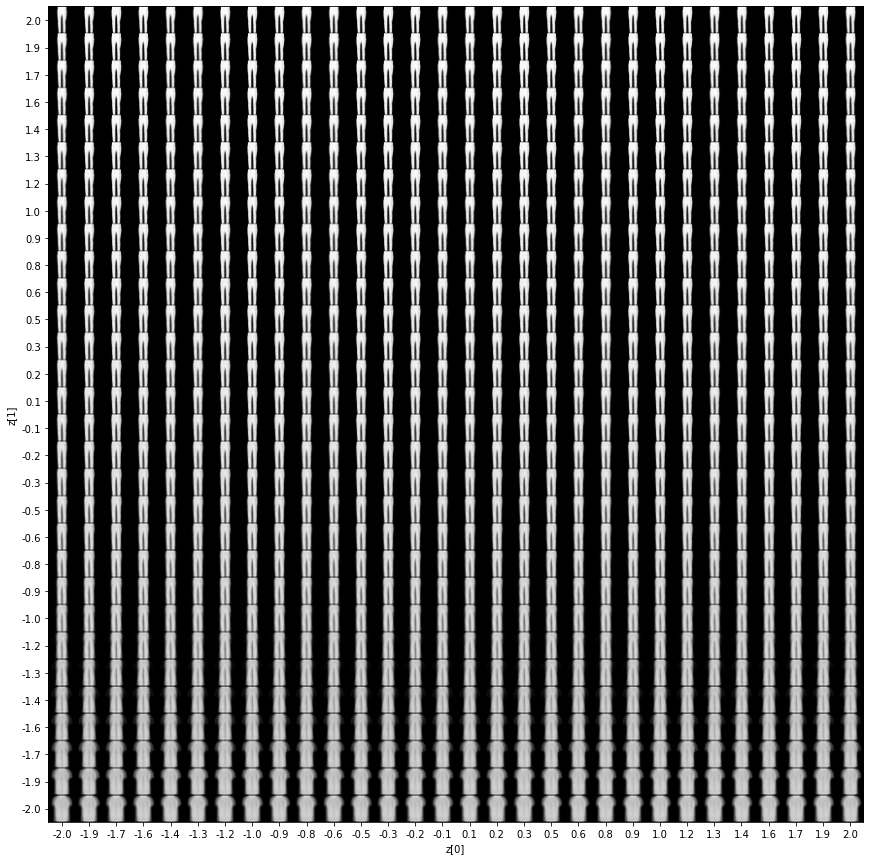

In [65]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    n = 30
    pic_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((pic_size * n, pic_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(pic_size, pic_size)
            figure[
                i * pic_size : (i + 1) * pic_size,
                j * pic_size : (j + 1) * pic_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = pic_size // 2
    end_range = n * pic_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, pic_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


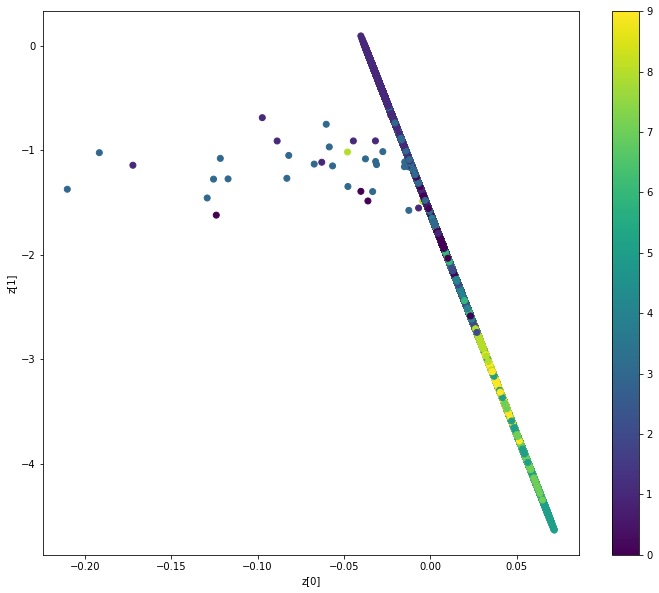

In [66]:

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)


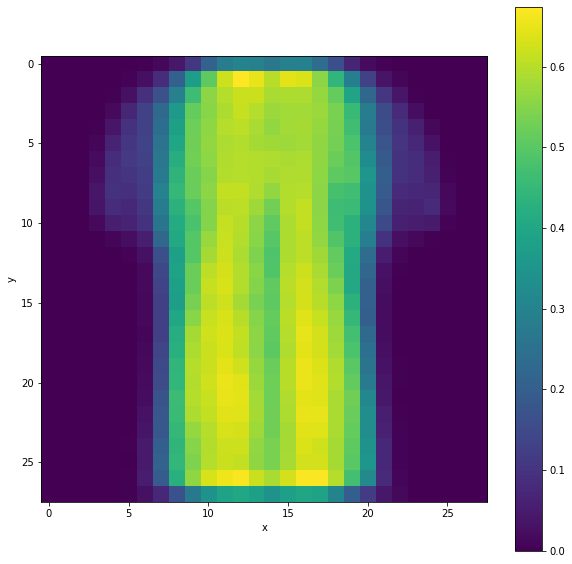

In [67]:
def plot_digit_from_decoder(decoder, z, pic_size):
    # display a 2D plot of the digit classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    digit = decoder.predict(data)
    digit = digit.reshape(pic_size, pic_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(digit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_digit_from_decoder(decoder, [-1,-1.6], 28)

## Вывод

Все измнения параметров, которые я производила приводили только к ухудшению работы нейросети. Из чего смогла сделать вывод, что, в первую очередь, на работе нейросети очень плохо сказывется добавление большого количества новых слоёв. Оптимизаторы все немного по-разному реагировали на изменения в encoder и decoder (выбирала из трёх оптимизаторов - Adam, Nadam и Adagrad, для разного количества слоёв разные оптимизаторы давали лучший результат).
Когда я увеличила количество слоёв до 6 (с контролем размерностей), картинка с изображением и вовсе превратилась в разноцветное полотно (даже без очертаний предмета).

Напечатанная картинка - лучшая из всех, которые я смогла получить. И, полагаю, сеть просто очень хорошо отреагировала на дополнительное обсучение (с batch_size=32).